# Cas Kaggle

Josep Maria Domingo Catafal, NIU: 1599946

## Outline

1. Introduccion
2. Data Exploration
3. Data Analysis
4. Preprocessing
5. Training and testing the models

## Introduction

Nowadays, most people buy online. This allows us to have a lot of data about the products and how they are received by the customers. It's very important when developing a new product to make sure it's something people will want to buy. So we can use all the data collected from online stores to predict if a product will have a good acceptance or not, and improve before releasing it if it doesn't.

In this case, we have information about all the different products of the Sephora online store. Sephora is a store specialized in cosmetics. Our goal will be to train different models in order to predict with the best accuracy as possible if the consumers of the store will like a product or not.

We are going to use the following libraries and modules:

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

## Data Exploration

The first step we need to take is to take a look into our data. What values does it contain? What do they tell us? If we take a look at the attributes of our dataset, we see the following:

| Feature | Type | Description |
|:---|:---|:---
| id | int | The product ID at Sephora's website |
| brand | object | The brand of the product at Sephora's website |
| category | Object | The category of the product at Sephora's website |
| name | Object | The name of the product at Sephora's website |
| size | Object | The size of the product |
| rating | float | The rating of the product |
| numberofreviews | int | The number of reviews of the product |
| love | int | The number of people loving the product |
| price | float | The price of the product |
| value_price |	float | The value price of the product (for discounted products) |
| URL | object | The URL link of the product |
| MarketingFlags | bool | The Marketing Flags of the product from the website if they were exclusive or sold online only |
| MarketingFlags_content | 	object | The kinds of Marketing Flags of the product |
| options | object | The options available on the website for the product like colors and sizes|
| details | object | Details of the product available on the website |
| howtouse | object | The instructions of the product if available |
| ingredients | object | The ingredients of the product if available |
| online_only | int | If the product is sold online only |
| exclusive | int | If the product is sold exclusively on Sephora's website |
| limited_edition | int | If the product is limited edition |
| limitedtimeoffer | int | The product has a limited time offer |


Most of these attributes are properties of the product in hand, but there's a few that are opinions given by the users of the website. Now we are going to load the dataset to analyze the data with a bit more detail.

In [2]:
df = pd.read_csv("data/sephora_website_dataset.csv").drop("URL", axis=1)
df.head(1)

,id,brand,category,name,size,rating,number_of_reviews,love,price,value_price,MarketingFlags,MarketingFlags_content,options,details,how_to_use,ingredients,online_only,exclusive,limited_edition,limited_time_offer
0,2218774,Acqua Di Parma,Fragrance,Blu Mediterraneo MINIATURE Set,5 x 0.16oz/5mL,4.0,4,3002,66.0,75.0,True,online only,no options,This enchanting set comes in a specially handc...,Suggested Usage:-Fragrance is intensified by t...,Arancia di Capri Eau de Toilette: Alcohol Dena...,1,0,0,0


In [3]:
print(f"There are {df.shape[0]} products with {df.shape[1]} attributes each")

There are 9168 products with 20 attributes each


Now we check how many NULL values we have in our dataset.

In [4]:
df.isnull().sum()

id                        0
brand                     0
category                  0
name                      0
size                      0
rating                    0
number_of_reviews         0
love                      0
price                     0
value_price               0
MarketingFlags            0
MarketingFlags_content    0
options                   0
details                   0
how_to_use                0
ingredients               0
online_only               0
exclusive                 0
limited_edition           0
limited_time_offer        0
dtype: int64

As we can see, there are no NULL values in the dataset. This is great because it means we have more data to work with, plus we don't have to do any preprocessing to treat the NULL values.

After looking at the dataset, it seems interesting to try to **predict the number of people that love a product**. This way, when we want to develop a new product, we can predict beforehand if it will be successful or not. Now, we will analyze the data in order to find patterns that will help us predict said value. 

It would probably be better to use the number of sales instead of the number of people that loved the product, since most people don't post reviews and maybe the people that buy a certain product are more inclined to post a review than others. But we don't have that information, so we will do it with the number of people that love the product.

# Data Analysis

In [5]:
df.describe(include=[np.number]).drop("count").T.style.background_gradient(cmap='plasma')

,mean,std,min,25%,50%,75%,max
id,1962951.784795,385971.360901,50.000000,1819453.000000,2072353.500000,2230591.000000,2359685.000000
rating,3.990020,1.007707,0.000000,4.000000,4.000000,4.500000,5.000000
number_of_reviews,282.139180,890.642028,0.000000,10.000000,46.000000,210.000000,19000.000000
love,16278.585079,42606.514471,0.000000,1600.000000,4800.000000,13800.000000,1300000.000000
price,50.063237,47.164989,2.000000,24.000000,35.000000,59.000000,549.000000
value_price,51.823590,49.459020,2.000000,25.000000,35.000000,60.000000,549.000000
online_only,0.234839,0.423921,0.000000,0.000000,0.000000,0.000000,1.000000
exclusive,0.264725,0.441211,0.000000,0.000000,0.000000,1.000000,1.000000
limited_edition,0.091841,0.288817,0.000000,0.000000,0.000000,0.000000,1.000000
limited_time_offer,0.000327,0.018087,0.000000,0.000000,0.000000,0.000000,1.000000


In [6]:
df.describe(exclude=[np.number]).drop("count").T

,unique,top,freq
brand,324,SEPHORA COLLECTION,496
category,143,Perfume,665
name,9106,Blush,4
size,1623,no size,3161
MarketingFlags,2,False,4786
MarketingFlags_content,10,0,4786
options,564,no options,8377
details,8839,no details,14
how_to_use,6497,no instructions,1573
ingredients,6962,unknown,1630


<AxesSubplot:>

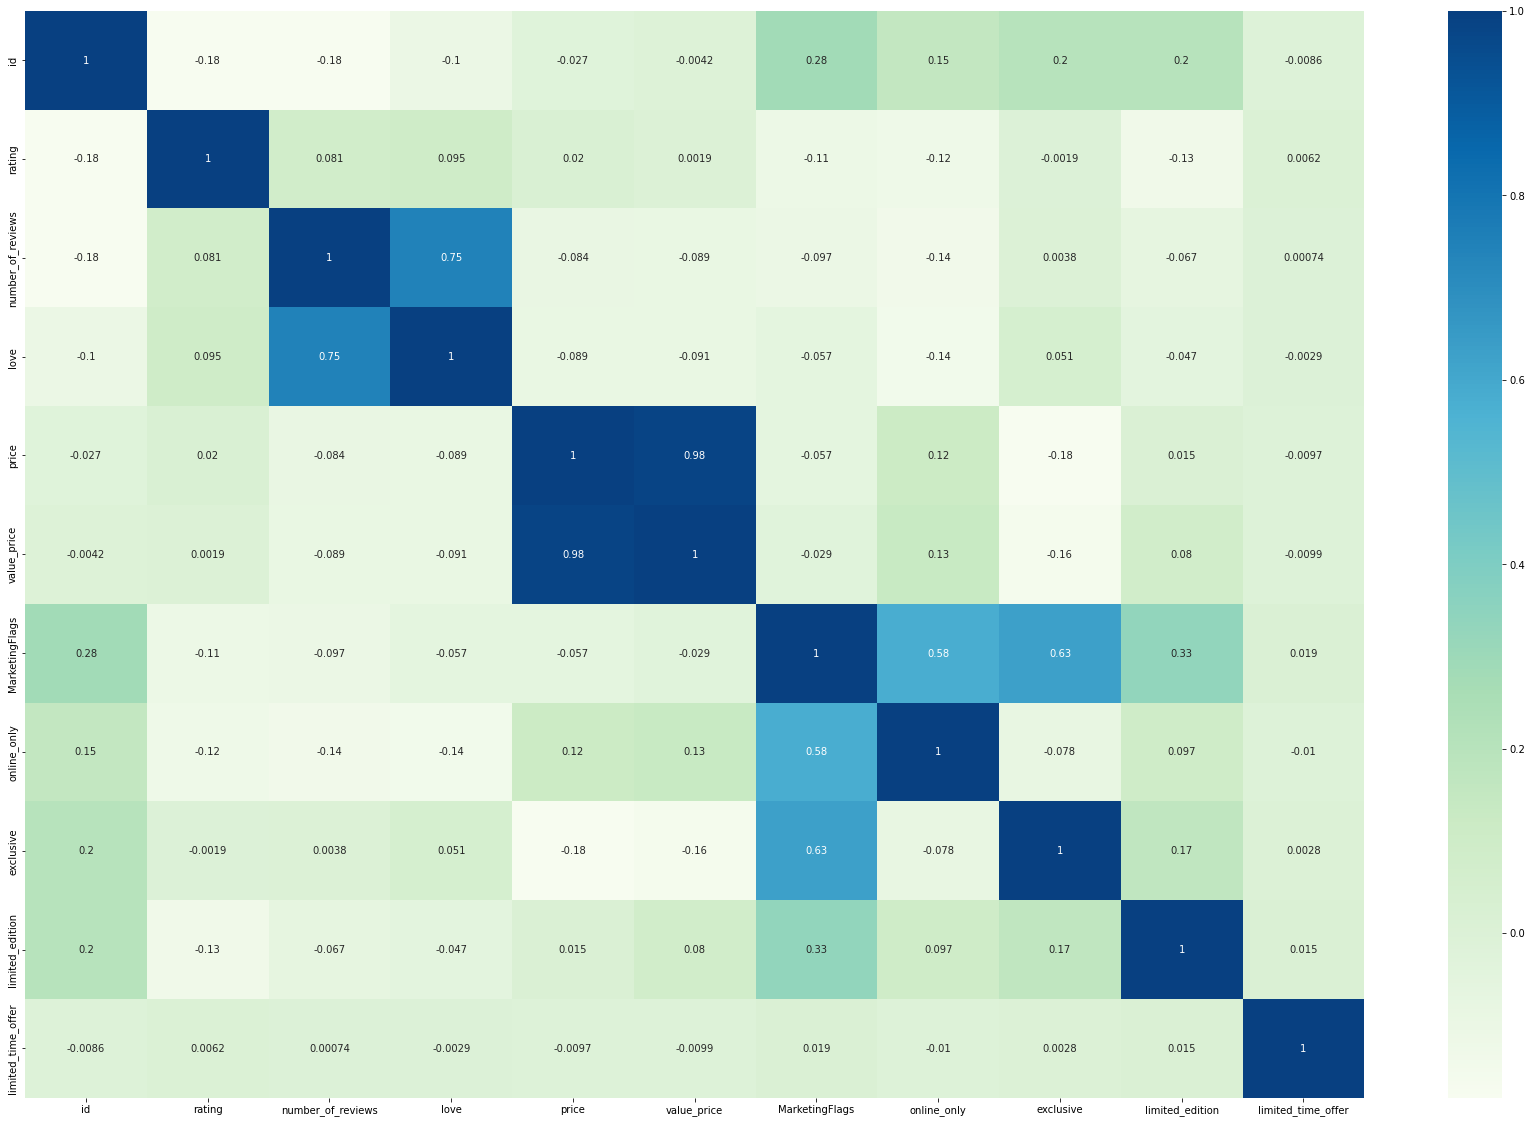

In [7]:
plt.figure(figsize=(30,20))
sns.heatmap(data = df.corr(),cmap='GnBu',annot=True)

There is a very strong correlation between "price" and "value_price", that's because the value price is the same as the price except when the product has received a discount, in which case the price is a little lower.

We can also see a strong correlation between the number of reviews and the number of people that love a product. Let's take a deeper look to see what's going on.

[Text(0, 0.5, 'love'), Text(0.5, 0, 'num. reviews')]

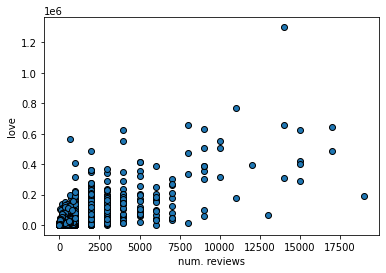

In [8]:
fig, ax = plt.subplots()
plt.scatter(y=df['love'], x=df['number_of_reviews'], edgecolors="black")
ax.set(ylabel="love", xlabel="num. reviews")

We can see that most points are clustered near the (0,0), so this means we are getting such high correlations because most products don't have neither reviews nor love.

Now we will take a look at how price affects the number of people that loves a product.

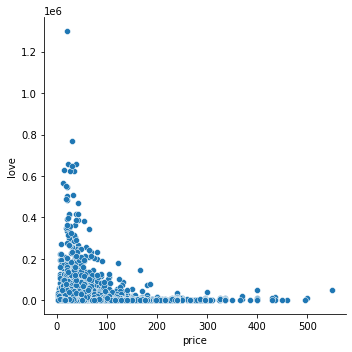

In [9]:
sns.relplot(x='price', y='love', data=df)

We can see that only products under 200 have a lot of people that loves them, beyond that not many people loves them or in most cases no one. If we had to choose a price to get the most love, we would set it below 50.

It may be interesting to take a look at the different categories and how they affect the love rate.

<AxesSubplot:xlabel='love', ylabel='category'>

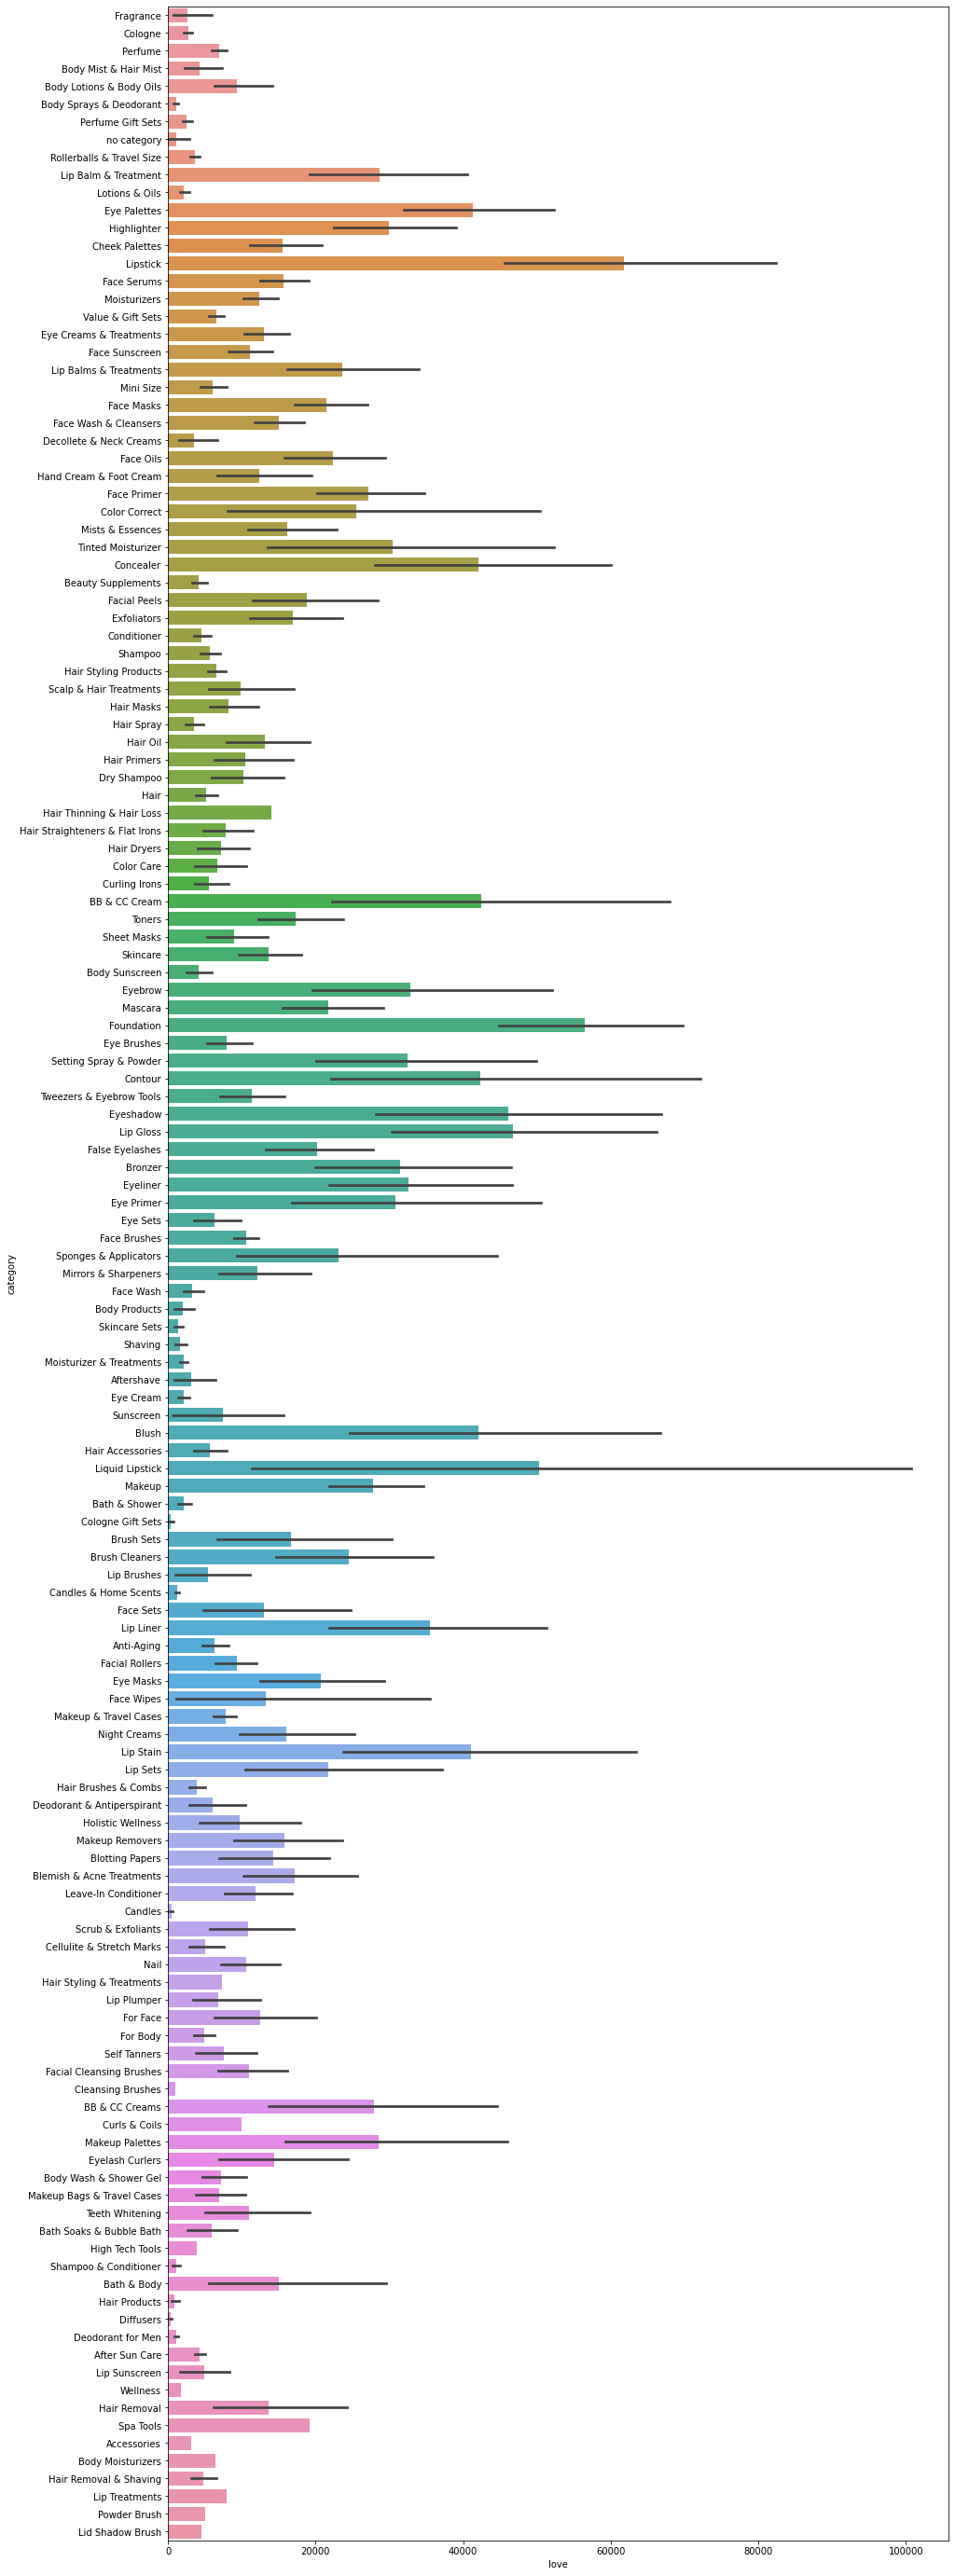

In [10]:
plt.figure(figsize=(15,50))
sns.barplot(x='love', y='category', data=df)

From the previous plot, we can observe that the lip products (most of them) are the most loved by people. There's also a lot of love for face creams, specially foundation. We can see it in a more contained numerical manner in the following table:

In [28]:
pd.DataFrame(df.groupby('category')['love'].mean()).sort_values(['love'], ascending = False).head(10)

,love
category,
Lipstick,61807.120419
Foundation,56526.932515
Liquid Lipstick,50341.666667
Lip Gloss,46736.240506
Eyeshadow,46124.756410
BB & CC Cream,42507.727273
Contour,42294.444444
Blush,42125.373134
Concealer,42086.000000


In the following table, we will take a look at how the love rating is affected by the fact that a product is a limited edition. The fact that it's "exclusive" may create the false illusion to the customer that that product is better and in turn have higher sales and more people that love it.

In [52]:
love = df.groupby("limited_edition")["love"].mean()
limited_edition = df.groupby("limited_edition")["limited_edition"].count()
ratio = love / limited_edition

pd.concat(
    [love, limited_edition, ratio],
    axis=1,
    keys=["love", "limited_edition", "ratio love/limited_edition"],
).sort_values(["ratio love/limited_edition"], ascending=False).head(10)

,love,limited_edition,ratio love/limited_edition
limited_edition,,,
1,10015.368171,842,11.894737
0,16911.977901,8326,2.031225


It turns out our assumption was correct and limited edition products have a higher ratio of love per number of products, quite a lot higher.

## Preprocessing the Data

Since we have categorical features we need to encode them. We will use **LabelEncoder** from Sklearn.

In [62]:
le = LabelEncoder()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.to_list()
df[categorical_cols] = df[categorical_cols].apply(lambda col: le.fit_transform(col))

We also need to separate the target column (love) from the rest. Once separeted we need to split both of them into train and test partitions.

In [63]:
X = df.drop('love', axis = 1)
y = df['love']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Something that is important in our case is standardizing the data, since the values of each feature is very different from those of the other features.

In [67]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Training and testing the models